In [1]:
import os, sys, copy
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import time, GPy
from sklearn.preprocessing import StandardScaler

from kernels.nn import ImplicitDenseNetKernel
from model.ick import ICK
from model.ick_cmgp import ICK_CMGP
from benchmarks.cmgp_modified import CMGP
from benchmarks.cevae_modified import *
from utils.train import CMGPEnsembleTrainer
from utils.losses import *
from utils.helpers import *

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Load and preprocess data

In [2]:
def load_and_preprocess_data(N_train, N_test):
    train_dir = '../../data/ACIC_challenge/high_dimensional_datasets/high1601.csv'
    train_df = pd.read_csv(train_dir)
    test_dir = '../../data/ACIC_challenge/TestDatasets_highD/highDim_testdataset1.csv'
    test_df = pd.read_csv(test_dir)
    test_eval_dir = '../../data/ACIC_challenge/TestDatasets_highD_cf/highDim_testdataset1_cf.csv'
    test_eval_df = pd.read_csv(test_eval_dir)
    for c in train_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            train_df[c] = scaler.fit_transform(train_df[c].to_numpy().reshape(-1,1)).reshape(-1)
    for c in test_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            test_df[c] = scaler.fit_transform(test_df[c].to_numpy().reshape(-1,1)).reshape(-1)

    # Training data
    X_train = train_df.to_numpy()[:N_train, 2:]
    T_train = train_df.to_numpy()[:N_train, 1][:,None]
    Y_train = train_df.to_numpy()[:N_train, 0][:,None]

    # Test data
    X_test = test_df.to_numpy()[:N_test, 2:]
    T_test = test_df.to_numpy()[:N_test, 1][:,None]
    Y_test = test_df.to_numpy()[:N_test, 0][:,None]
    mu0_test = test_eval_df.to_numpy()[:N_test, -1][:,None]
    mu1_test = test_eval_df.to_numpy()[:N_test, -2][:,None]
    mu_test = mu1_test - mu0_test
    data = {'X_train': X_train, 'T_train': T_train, 'Y_train': Y_train, 'X_test': X_test, 'mu_test': mu_test}

    # Initialize dataloaders
    data_train = [X_train, T_train]
    data_test = [X_test, T_test]
    data_generators = create_generators_from_data(data_train, Y_train, data_test, Y_test, 
                                                  train_batch_size=256, test_batch_size=1000)
    return data_generators, data

# 2. Define ICK-CMGP model

In [3]:
def build_ick_cmgp_ensemble(input_dim, load_weights=False):
    alpha11, alpha12, alpha13 = 1.0, 1.0, 1.0
    alpha21, alpha22, alpha23 = 1.0, 1.0, 1.0
    num_estimators = 10

    ensemble, ensemble_weights = [], {}
    for i in range(num_estimators):
        f11 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f12 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f13 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f21 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f22 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f23 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        if load_weights:
            for f in ['f11', 'f12', 'f13', 'f21', 'f22', 'f23']:
                eval(f).kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)][f])
        else:
            model_weights = {
                'f11': f11.kernels[0].state_dict(), 'f12': f12.kernels[0].state_dict(), 'f13': f13.kernels[0].state_dict(), 
                'f21': f21.kernels[0].state_dict(), 'f22': f22.kernels[0].state_dict(), 'f23': f23.kernels[0].state_dict()
            }
            ensemble_weights['model_'+str(i+1)] = model_weights
        baselearner = ICK_CMGP(
            control_components=[f11,f21], treatment_components=[f12,f22], shared_components=[f13,f23],
            control_coeffs=[alpha11,alpha21], treatment_coeffs=[alpha12,alpha22], shared_coeffs=[alpha13,alpha23], 
            coeff_trainable=True, output_binary=True
        )
        ensemble.append(baselearner)
    if not load_weights:
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')
        torch.save(ensemble_weights, './checkpoints/ick_cmgp_acic.pt')

    return ensemble

# 3. Training and evaluation of ICK-CMGP model

In [4]:
def fit_and_evaluate_ick_cmgp(ensemble, data_generators, mu_test, lr, treatment_index=1):
    # The index of "T_train" in "data_train" is 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = 'sgd'
    optim_params = {
        'lr': lr, 
        'momentum': 0.99,
        'weight_decay': 1e-4
    }
    epochs, patience = 1000, 10
    trainer = CMGPEnsembleTrainer(
        model=ensemble,
        data_generators=data_generators,
        optim=optim,
        optim_params=optim_params, 
        model_save_dir=None,
        device=device,
        epochs=epochs,
        patience=patience, 
        treatment_index=treatment_index
    )
    train_start = time.time()
    trainer.train()
    train_time = time.time() - train_start
    
    mean_test_pred, std_test_pred, y_test_true = trainer.predict()
    mu_test_pred = mean_test_pred[:,1] - mean_test_pred[:,0]
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (ICK-CMGP):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 4. Benchmark 1: original CMGP

In [5]:
def fit_and_evaluate_original_cmgp(data):
    X_train, T_train, Y_train = data['X_train'], data['T_train'], data['Y_train']
    X_test, mu_test = data['X_test'], data['mu_test']
#     K0 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.1, bias_variance=0.1, ARD=False)
#     K1 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.2, bias_variance=0.2, ARD=False)
    train_start = time.time()
    cmgp_model = CMGP(X_train, T_train, Y_train)
    train_time = time.time() - train_start
    
    mu0_test_pred, mu1_test_pred = cmgp_model.predict(X_test, return_var=False)
    mu_test_pred = mu1_test_pred - mu0_test_pred
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CMGP):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 5. Benchmark 2: CEVAE

In [6]:
def fit_and_evaluate_cevae(data):
    lr = 1e-4
    weight_decay = 1e-4
    batch_size = int(data['X_train'].shape[0]/8)
    train_iters = 20000
    eval_iters = 200
    latent_dim = 20
    n_h = 64
    X_train, T_train, Y_train, X_test = torch.tensor(data['X_train']).float(), torch.tensor(data['T_train']).float(), \
                                        torch.tensor(data['Y_train']).float(), torch.tensor(data['X_test']).float()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # init networks (overwritten per replication)
    p_x_z_dist = p_x_z(dim_in=latent_dim, nh=3, dim_h=n_h).to(device)
    p_t_z_dist = p_t_z(dim_in=latent_dim, nh=1, dim_h=n_h, dim_out=1).to(device)
    p_y_zt_dist = p_y_zt(dim_in=latent_dim, nh=3, dim_h=n_h, dim_out=1, output_binary=True).to(device)
    q_t_x_dist = q_t_x(dim_in=X_train.shape[1], nh=1, dim_h=n_h, dim_out=1).to(device)

    # t is not feed into network, therefore not increasing input size (y is fed).
    q_y_xt_dist = q_y_xt(dim_in=X_train.shape[1], nh=3, dim_h=n_h, dim_out=1, output_binary=True).to(device)
    q_z_tyx_dist = q_z_tyx(dim_in=X_train.shape[1]+1, nh=3, dim_h=n_h, dim_out=latent_dim).to(device)
    p_z_dist = normal.Normal(torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))

    # Create optimizer
    params = list(p_x_z_dist.parameters()) + \
             list(p_t_z_dist.parameters()) + \
             list(p_y_zt_dist.parameters()) + \
             list(q_t_x_dist.parameters()) + \
             list(q_y_xt_dist.parameters()) + \
             list(q_z_tyx_dist.parameters())

    # Adam is used, like original implementation, in paper Adamax is suggested
    optimizer = optim.Adamax(params, lr=lr, weight_decay=weight_decay)

    # init q_z inference
    q_z_tyx_dist = init_qz(q_z_tyx_dist, Y_train, T_train, X_train)

    # Training
    loss = []
    train_start = time.time()
    for _ in trange(train_iters):
        i = np.random.choice(X_train.shape[0],size=batch_size,replace=False)
        Y_train_shuffled = Y_train[i,:]
        X_train_shuffled = X_train[i,:]
        T_train_shuffled = T_train[i,:]

        # inferred distribution over z
        xy = torch.cat((X_train_shuffled, Y_train_shuffled), 1)
        z_infer = q_z_tyx_dist(xy=xy, t=T_train_shuffled)
        # use a single sample to approximate expectation in lowerbound
        z_infer_sample = z_infer.sample()        

        # RECONSTRUCTION LOSS
        # p(x|z)
        x_con = p_x_z_dist(z_infer_sample)
        # l1 = x_bin.log_prob(x_train).sum(1)

        l2 = x_con.log_prob(X_train_shuffled).sum(1)

        # p(t|z)
        t = p_t_z_dist(z_infer_sample)
        l3 = t.log_prob(T_train_shuffled).squeeze()

        # p(y|t,z)
        # for training use trt_train, in out-of-sample prediction this becomes t_infer
        y = p_y_zt_dist(z_infer_sample, T_train_shuffled)
        l4 = y.log_prob(Y_train_shuffled).squeeze()

        # REGULARIZATION LOSS
        # p(z) - q(z|x,t,y)
        # approximate KL
        l5 = (p_z_dist.log_prob(z_infer_sample) - z_infer.log_prob(z_infer_sample)).sum(1)

        # AUXILIARY LOSS
        # q(t|x)
        t_infer = q_t_x_dist(X_train_shuffled)
        l6 = t_infer.log_prob(T_train_shuffled).squeeze()

        # q(y|x,t)
        y_infer = q_y_xt_dist(X_train_shuffled, T_train_shuffled)
        l7 = y_infer.log_prob(Y_train_shuffled).squeeze()

        # Total objective
        # inner sum to calculate loss per item, torch.mean over batch
        loss_mean = torch.mean(l2 + l3 + l4 + l5 + l6 + l7)
        loss.append(loss_mean.cpu().detach().numpy())
        objective = -loss_mean

        optimizer.zero_grad()
        # Calculate gradients
        objective.backward()
        # Update step
        optimizer.step()
    train_time = time.time() - train_start
        
    # Evaluation
    Y0_pred, Y1_pred = [], []
    t_infer = q_t_x_dist(X_test)

    eval_iters = 1000
    for _ in trange(eval_iters):
        ttmp = t_infer.sample()
        y_infer = q_y_xt_dist(X_test, ttmp)

        xy = torch.cat((X_test, y_infer.sample()), 1)
        z_infer = q_z_tyx_dist(xy=xy, t=ttmp).sample()
        y0 = p_y_zt_dist(z_infer, torch.zeros(z_infer.shape[0],1).to(device)).sample()
        y1 = p_y_zt_dist(z_infer, torch.ones(z_infer.shape[0],1).to(device)).sample()
        Y0_pred.append(y0.detach().cpu().numpy().ravel())
        Y1_pred.append(y1.detach().cpu().numpy().ravel())

    # sameple from the treated and control    
    mu0_test_pred = np.mean(np.array(Y0_pred), axis=0)
    mu1_test_pred = np.mean(np.array(Y1_pred), axis=0)
    mu_test_pred = mu1_test_pred - mu0_test_pred
    mu_test = data['mu_test']
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CEVAE):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 6. Main function

In [7]:
def main():
    N_train = [100,200,300,400,500,1000,1500,2000]
    N_test = [2000] * len(N_train)
    lrs = [1e-3,8e-4,6e-4,6e-4,6e-4,2e-4,1.5e-4,1e-4]
    res = {k: {} for k in N_train}
    for i in trange(len(N_train)):
        data_generators, data = load_and_preprocess_data(N_train[i], N_test[i])
        input_dim = data['X_train'].shape[1]
        # Make sure the ICK-CMGP ensemble has the same starting point for each experimental run
        ensemble = build_ick_cmgp_ensemble(input_dim, load_weights=(i!=0))
        sqrt_pehe_ick_cmgp, train_time_ick_cmgp = fit_and_evaluate_ick_cmgp(
            ensemble, data_generators, data['mu_test'], lr=lrs[i])
        res[N_train[i]]['sqrt_pehe_ick_cmgp'] = sqrt_pehe_ick_cmgp
        res[N_train[i]]['train_time_ick_cmgp'] = train_time_ick_cmgp
        sqrt_pehe_cmgp, train_time_cmgp = fit_and_evaluate_original_cmgp(data)
        res[N_train[i]]['sqrt_pehe_cmgp'] = sqrt_pehe_cmgp
        res[N_train[i]]['train_time_cmgp'] = train_time_cmgp
        sqrt_pehe_cevae, train_time_cevae = fit_and_evaluate_cevae(data)
        res[N_train[i]]['sqrt_pehe_cevae'] = sqrt_pehe_cevae
        res[N_train[i]]['train_time_cevae'] = train_time_cevae
    if not os.path.exists('./Results'):
        os.makedirs('./results')
    with open('./results/acic_challenge_results.pkl', 'wb') as fp:
        pkl.dump(res, fp)

if __name__ == "__main__":
    main()

  0%|          | 0/8 [00:00<?, ?it/s]

Training started:

Epoch 1/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2711
Validation:
3s - loss 0.2384

Epoch 2/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2701
Validation:
3s - loss 0.2370

Epoch 3/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2681
Validation:
3s - loss 0.2351

Epoch 4/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2652
Validation:
3s - loss 0.2326

Epoch 5/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2615
Validation:
3s - loss 0.2296

Epoch 6/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2572
Validation:
3s - loss 0.2262

Epoch 7/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2523
Validation:
3s - loss 0.2226

Epoch 8/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2471
Validation:
3s - loss 0.2188

Epoch 9/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2418
Validation:
3s - loss 0.2150

Epoch 10/1000
Learning rate: 0.001000
Training time - 0s - loss 0.2366
Validation

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.1313
Training started:

Epoch 1/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2703
Validation:
4s - loss 0.2385

Epoch 2/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2695
Validation:
4s - loss 0.2375

Epoch 3/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2679
Validation:
4s - loss 0.2359

Epoch 4/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2656
Validation:
4s - loss 0.2339

Epoch 5/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2627
Validation:
4s - loss 0.2314

Epoch 6/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2591
Validation:
4s - loss 0.2287

Epoch 7/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2551
Validation:
3s - loss 0.2256

Epoch 8/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2508
Validation:
4s - loss 0.2224

Epoch 9/1000
Learning rate: 0.000800
Training time - 1s - loss 0.2463
Validation:
4s - loss 0.2190

Epoch 10/1000
Learning rate: 0.000800
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.1076
Training started:

Epoch 1/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2705
Validation:
4s - loss 0.2380

Epoch 2/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2687
Validation:
4s - loss 0.2355

Epoch 3/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2647
Validation:
4s - loss 0.2315

Epoch 4/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2590
Validation:
4s - loss 0.2263

Epoch 5/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2519
Validation:
4s - loss 0.2206

Epoch 6/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2441
Validation:
4s - loss 0.2148

Epoch 7/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2368
Validation:
4s - loss 0.2092

Epoch 8/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2305
Validation:
4s - loss 0.2042

Epoch 9/1000
Learning rate: 0.000600
Training time - 1s - loss 0.2254
Validation:
4s - loss 0.1999

Epoch 10/1000
Learning rate: 0.000600
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0732
Training started:

Epoch 1/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2693
Validation:
3s - loss 0.2377

Epoch 2/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2668
Validation:
3s - loss 0.2349

Epoch 3/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2621
Validation:
3s - loss 0.2305

Epoch 4/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2553
Validation:
3s - loss 0.2251

Epoch 5/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2474
Validation:
3s - loss 0.2190

Epoch 6/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2392
Validation:
3s - loss 0.2127

Epoch 7/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2308
Validation:
3s - loss 0.2067

Epoch 8/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2236
Validation:
3s - loss 0.2014

Epoch 9/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2175
Validation:
3s - loss 0.1971

Epoch 10/1000
Learning rate: 0.000600
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


PEHE (CMGP):             0.1565


 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0768
Training started:

Epoch 1/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2694
Validation:
3s - loss 0.2378

Epoch 2/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2670
Validation:
4s - loss 0.2349

Epoch 3/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2623
Validation:
4s - loss 0.2306

Epoch 4/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2557
Validation:
3s - loss 0.2254

Epoch 5/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2480
Validation:
4s - loss 0.2195

Epoch 6/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2396
Validation:
3s - loss 0.2134

Epoch 7/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2317
Validation:
3s - loss 0.2075

Epoch 8/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2250
Validation:
3s - loss 0.2022

Epoch 9/1000
Learning rate: 0.000600
Training time - 2s - loss 0.2195
Validation:
3s - loss 0.1978

Epoch 10/1000
Learning rate: 0.000600
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


PEHE (CMGP):             0.1705


 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0723
Training started:

Epoch 1/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2687
Validation:
3s - loss 0.2375

Epoch 2/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2648
Validation:
3s - loss 0.2334

Epoch 3/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2575
Validation:
3s - loss 0.2274

Epoch 4/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2477
Validation:
3s - loss 0.2202

Epoch 5/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2363
Validation:
3s - loss 0.2126

Epoch 6/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2251
Validation:
3s - loss 0.2055

Epoch 7/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2155
Validation:
3s - loss 0.1995

Epoch 8/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2088
Validation:
3s - loss 0.1951

Epoch 9/1000
Learning rate: 0.000200
Training time - 4s - loss 0.2047
Validation:
3s - loss 0.1924

Epoch 10/1000
Learning rate: 0.000200
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0886
Training started:

Epoch 1/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2688
Validation:
3s - loss 0.2365

Epoch 2/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2626
Validation:
3s - loss 0.2302

Epoch 3/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2513
Validation:
3s - loss 0.2214

Epoch 4/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2376
Validation:
3s - loss 0.2118

Epoch 5/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2239
Validation:
3s - loss 0.2031

Epoch 6/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2125
Validation:
3s - loss 0.1968

Epoch 7/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2070
Validation:
3s - loss 0.1930

Epoch 8/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2055
Validation:
3s - loss 0.1915

Epoch 9/1000
Learning rate: 0.000150
Training time - 6s - loss 0.2071
Validation:
3s - loss 0.1915

Epoch 10/1000
Learning rate: 0.000150
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0956
Training started:

Epoch 1/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2686
Validation:
3s - loss 0.2361

Epoch 2/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2616
Validation:
3s - loss 0.2290

Epoch 3/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2489
Validation:
3s - loss 0.2194

Epoch 4/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2343
Validation:
3s - loss 0.2094

Epoch 5/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2206
Validation:
3s - loss 0.2010

Epoch 6/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2110
Validation:
3s - loss 0.1952

Epoch 7/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2068
Validation:
3s - loss 0.1922

Epoch 8/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2073
Validation:
3s - loss 0.1913

Epoch 9/1000
Learning rate: 0.000100
Training time - 8s - loss 0.2101
Validation:
3s - loss 0.1916

Epoch 10/1000
Learning rate: 0.000100
Training t

 /Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning:Initializing zero-element tensors is a no-op


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PEHE (CEVAE):             0.0939


# 7. Visualize the results

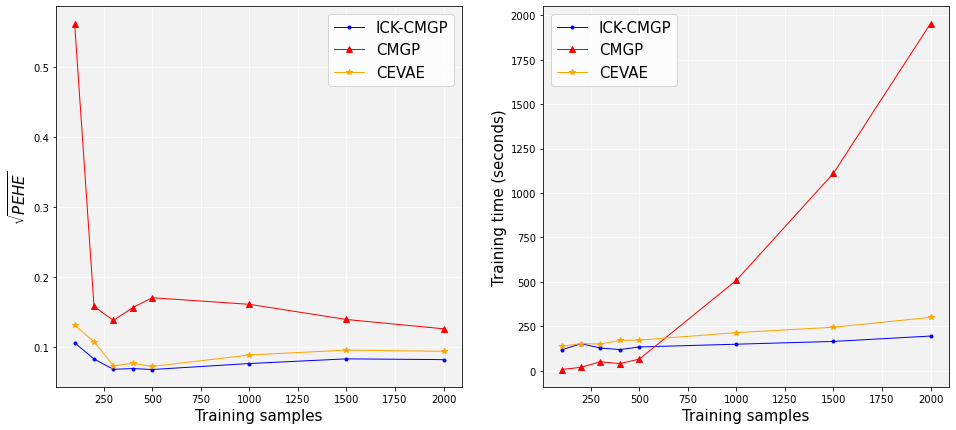

In [9]:
with open('./results/acic_challenge_results.pkl', 'rb') as fp:
    res = pkl.load(fp)

fig, axs = plt.subplots(1,2,figsize=(16,7))
training_samples = list(res.keys())
sqrt_pehe_ick_cmgp = [x['sqrt_pehe_ick_cmgp'] for x in list(res.values())]
sqrt_pehe_cmgp = [x['sqrt_pehe_cmgp'] for x in list(res.values())]
sqrt_pehe_cevae = [x['sqrt_pehe_cevae'] for x in list(res.values())]
axs[0].plot(training_samples, sqrt_pehe_ick_cmgp, lw=1, color='blue', marker='.', label='ICK-CMGP')
axs[0].plot(training_samples, sqrt_pehe_cmgp, lw=1, color='red', marker='^', label='CMGP')
axs[0].plot(training_samples, sqrt_pehe_cevae, lw=1, color='orange', marker='*', label='CEVAE')
axs[0].set_xlabel('Training samples', fontsize=15)
axs[0].set_ylabel('$\sqrt{PEHE}$', fontsize=15)
axs[0].set_facecolor('#F2F2F2')
axs[0].grid(color='white')
axs[0].legend(fontsize=15)
train_time_ick_cmgp = [x['train_time_ick_cmgp'] for x in list(res.values())]
train_time_cmgp = [x['train_time_cmgp'] for x in list(res.values())]
train_time_cevae = [x['train_time_cevae'] for x in list(res.values())]
axs[1].plot(training_samples, train_time_ick_cmgp, lw=1, color='blue', marker='.', label='ICK-CMGP')
axs[1].plot(training_samples, train_time_cmgp, lw=1, color='red', marker='^', label='CMGP')
axs[1].plot(training_samples, train_time_cevae, lw=1, color='orange', marker='*', label='CEVAE')
axs[1].set_xlabel('Training samples', fontsize=15)
axs[1].set_ylabel('Training time (seconds)', fontsize=15)
axs[1].set_facecolor('#F2F2F2')
axs[1].grid(color='white')
axs[1].legend(fontsize=15)

if not os.path.exists('./Figures'):
    os.makedirs('./Figures')
plt.savefig('./Figures/acic_challenge_results.pdf', dpi=300, bbox_inches='tight')